Reference : https://www.stat.auckland.ac.nz/~ihaka/726/notes.pdf

# What is Time series?

Time series arise as recordings of processes which vary over time. (예를 들어, 풍향/풍속 데이터입니다. 즉 시간에 따른 일련의 데이터를 의미합니다.)

A recording
can either be a continuous trace or a set of discrete observations. We will
concentrate on the case where observations are made at discrete equally spaced
times.

 - Observation times : $1, 2 ,..., T$
 - Observations : $Y_1, Y_2,..., Y_T$



Time series는 일반적으로 4개의 요소 (Trend, Cyclical, Seasonal 그리고 Irregular)에 의해 영향을 받습니다.

- **Trend(추세)**	: 장기적인 관점에서 봤을때 그래프가 증가하는지, 감소하는지, 또는 정체되어 있는지등의 추세를 Trend라고 합니다. Trend는 따라서 time series안에서 long term movement를 보는 것이 중요합니다.
- **Seasonality(계절성)** : 특정 구간동안의 (1년, 한달, 일주일..) 변동성(fluctuations)를 나타냅니다. 예를 들어서 아이스크림 판매량은 여름에 늘어나고, 외투는 겨운에 판매량이 늘어날 것입니다. 또는 피트니스센터의 고객은 매년 결심을 하는 1월 초에 가장많은 사람들이 나올것입니다. 하지만 매월초가 될수도 있고, 매주초가 될 수도 있습니다. 따라서 피트니스센터는 년, 월, 주단위 seasonality를 갖고 있다고 할수 있습니다.
- **Cycle(주기)** : Seasonality는 특정 기간에 정확하게 나타나는 변동성을 갖고 있는 반면, Cycle의 경우 특정 시간에 구애 받지 않습니다. 하지만 동일하게 특정 패턴을 갖고 있습니다. 보통 2~3년처럼 장기간에 걸친 패턴을 갖고 있을수 있습니다. 예를 들어서 business cycle의 경우에는 호황 -> 불황 -> 침체 -> 회복 의 cycle을 갖고 있습니다.
- **Irregularity(불규칙성)** : 또는 random variations이라고 불리며 예상치 못한 영향에 의해서 나타납니다. 예를 들어서 전쟁, 지진, 홍수, 혁명등등이 될 수 있습니다.

# Stationarity and Non-Stationrarity

*Stationarity*는 time series에서 중요한 개념입니다. 간단하게 설명하면, 시간이 흘러도 time series의 행동이 바뀌지 않을때 time series는 stationary 합니다. 우리가 접하게 되는 time series는 모두 stationary 하지는 않습니다.(non-stationary time series)

- Trend model : 
    - sum of a deterministric *trend* series and a stationary *noise* series : $Y_t=\beta_0 + \beta_1t + \epsilon_t$
    - sum of a periodic *seasonal* effect and stationary *noise*

- Integrated model : 관찰된 time series가 $Y_{t+1}-Y_{t}=\epsilon_{t+1}$을 만족하는 경우 ($\epsilon_t$ : a stationary series)

# ARIMA

ARIMA는 time series foracasting model입니다. 모델링이 진행되면서 3가지 중요한 parameter를 찾습니다.
 - Auto Regression(AR) : 이전 값들의 lags을 위한 term입니다.
 - Integral(I) : non-stationary differencing을 위한 term입니다.
 - Moving Average(MA) : error를 위한 term입니다.

ARIMA 모델에 대하여,
 - ARIMA, SARIMA, ARIMAX 모델을 각각 이해
 - ARIMA를 이용한 테스트에 대한 이해
 - 통계 테스트 및 시각화를 통하여 통계적으로 의미있는 parameter set을 찾는 것에 대한 이해

___

# 데이터 로딩

In [18]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

plt.style.use('ggplot')
color = sns.color_palette()

In [2]:
from subprocess import check_output
print(check_output(['ls', './inputs']).decode('utf-8'))

HR-Employee-Attrition.csv
benz_train.csv
click_rates.csv
creditcard.csv
e-commerce-data.csv
four_sessions.csv
german_credit_data.csv
housing.csv
murders.csv
ratings_test.txt
ratings_train.txt
scores.csv
selected_reviews
spam.csv
state-population.csv
superstore.xls
ts_train.csv
web_page_data.csv
winequality-data.csv



In [3]:
train = pd.read_csv('./inputs/ts_train.csv')
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [5]:
# Datetime으로 변경
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")
train.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [6]:
train.shape

(913000, 4)

# Forecast modeling using ARIMA

ARIMA model은 AR, I, MA term을 가지고 있습니다.

 - I term은 full difference입니다. 즉 $t$시점에서의 value에서 $t-1$시점에서의 value의 차이를 구하면 됩니다.
 - AR term은 partial difference입니다. AR term에서의 coefficient는 부분적으로 취해야하는 difference의 비율(percentage)를 나타냅니다.
 - MA : Moving Average(MA) term은 과거의 에러를 나타냅니다. $Y_t=\alpha + \epsilon_t + \phi_{1}\epsilon_{t-1} + \phi_{2}\epsilon_{t-2} + ... + \phi_{q}\epsilon_{t-q}$

In [28]:
# 1번 store, 1번 item
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]

train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [29]:
print(train.shape)
print(train_df.shape)

(913000, 4)
(1826, 8)


데이터가 저장된 기간을 살펴보겠습니다.

In [30]:
print(train.date.min())
print(train.date.max())

2013-01-01 00:00:00
2017-12-31 00:00:00


## (1) Decompose the time series
데이터가 저장된 기간을 살펴보면 총 5년 동안의 데이터임을 알 수 있습니다. 따라서 yearly, weekly pattern이 존재할 수 있다고 가정할 수 있습니다. `statsmodels`를 이용하여 Seasonality, trend, residual를 구분해보겠습니다.

1번 store에서, 1번 item에 대한 데이터를 이용하여 분석하겠습니다.

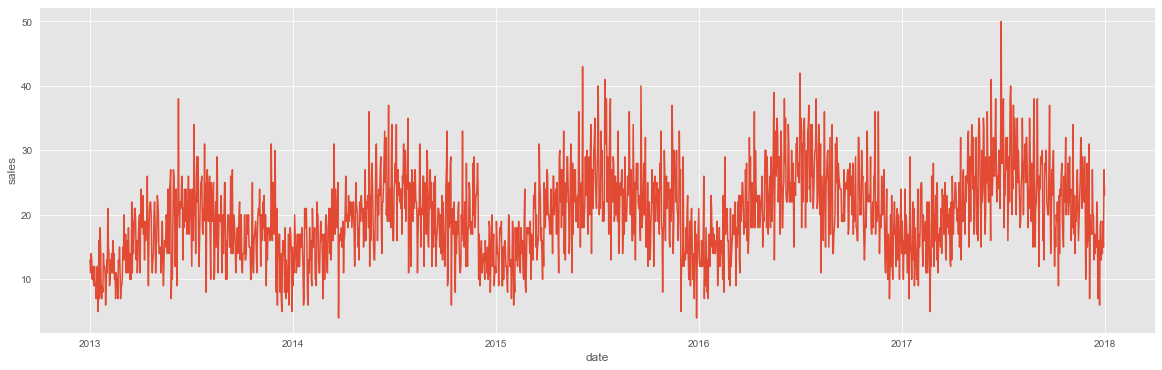

In [31]:
# Yearly pattern
figure = plt.figure(figsize=(20, 6))
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

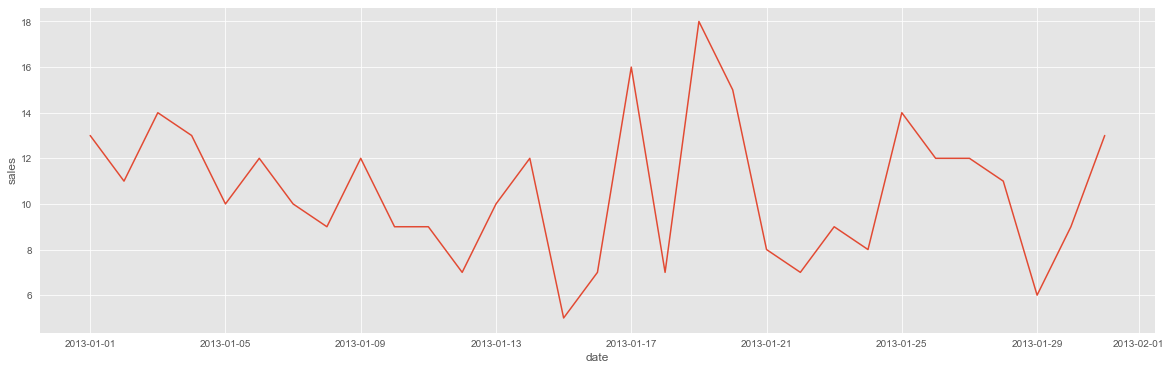

In [32]:
# 처음 1달간 데이터
figure = plt.figure(figsize=(20, 6))
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:31])

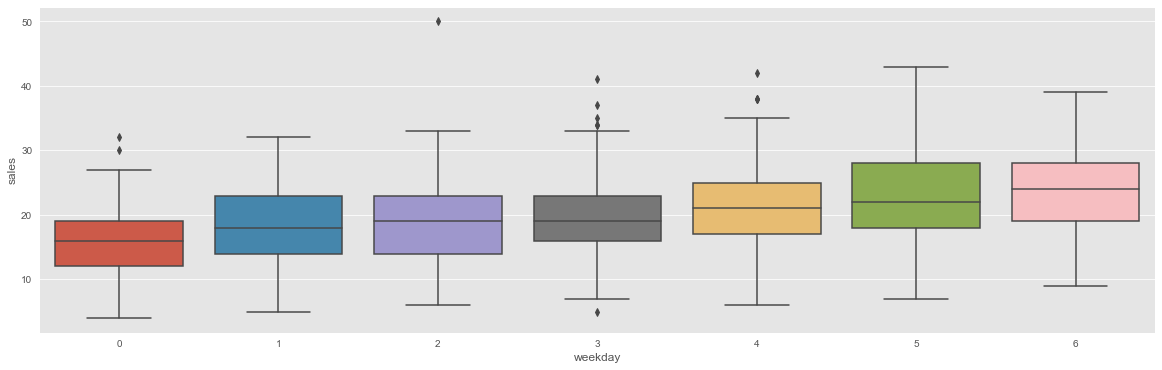

In [33]:
# 요일별 판매량의 분포
figure = plt.figure(figsize=(20, 6))
sns.boxplot(x="weekday", y="sales", data=train_df)

주말의 판매량이 높고, 월/수 는 outlier가 존재합니다.

`date` 컬럼을 index로 설정합니다.

In [34]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)

train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


`seasonal_decompose`를 이용하여, season의 pattern, trend를 찾아봅니다.

*model* argument에서는 2가지 중(additive, multiplicative) 하나를 선택합니다.
- additive : $Y[t] = T[t] + S[t] + e[t]$
- multiplicative : $Y[t] = T[t] * S[t] * e[t]$

> additive

<Figure size 432x288 with 0 Axes>

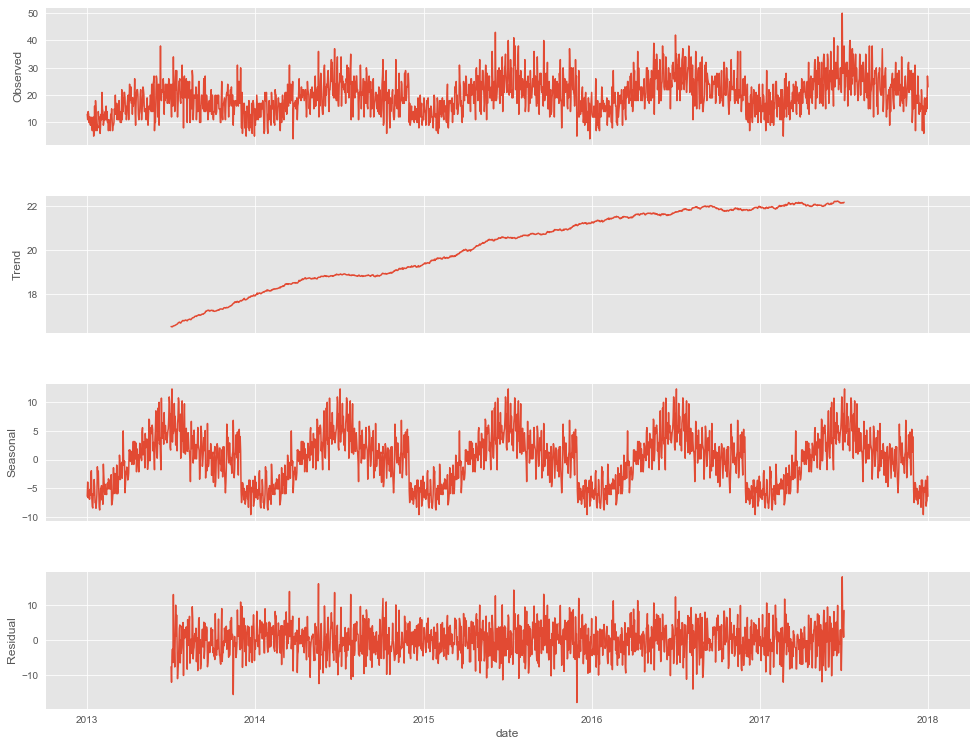

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

> multiplicative

<Figure size 432x288 with 0 Axes>

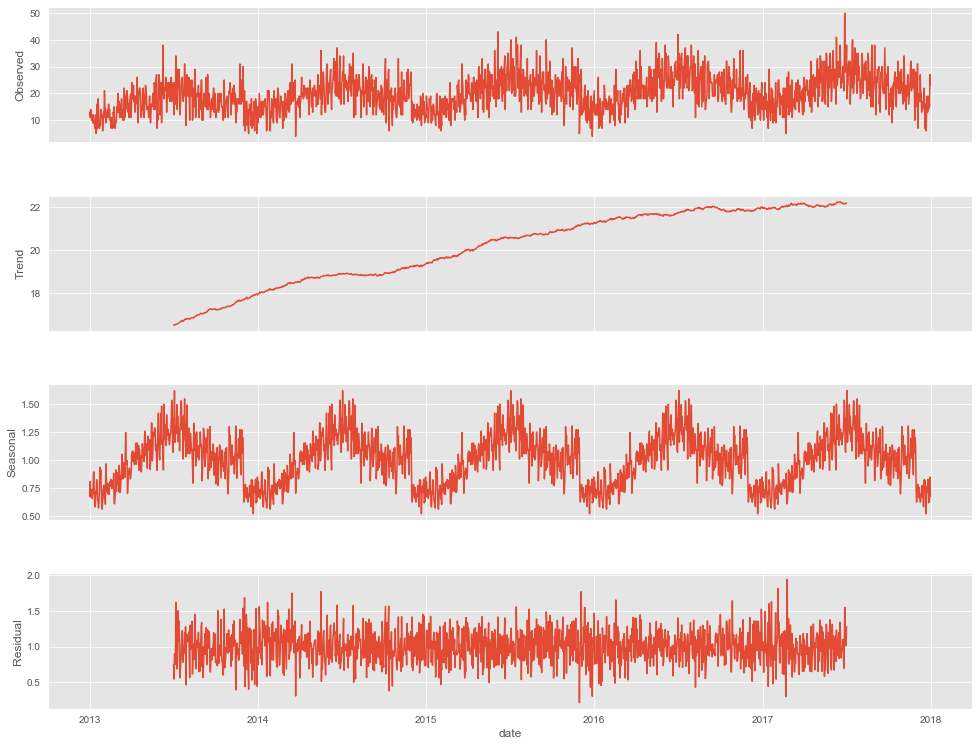

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='multiplicative', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

###  Stationarize the data:

Data가 stationary 되어야 한다는 것이 무슨 의미일까?

- $E(x_t)=\mu$, Series의 평균이 시간의 함수가 되면 안됩니다.  아래의 그래프를 살펴보면 왼쪽은 stationary series이지만, 오른쪽은 non-stationary series입니다. 왜냐하면 시간이 지남에 따라서 평균이 증가하기 때문입니다. 즉, 평균이 시간의 함수가 되는것을 보여주고 있습니다. 
![alt text](https://imgur.com/LjtBXwf.png)

- $E[(x_t-\mu)^2]=Var(x_t)=\sigma^2$, Series의 분산이 시간의 함수가 되면 안됩니다. 이것은 homoscedasticity(동분산성)으로 알려져 있습니다. 선형회귀모형의 가정에서 나온, 잔차의 분산이 일정한 상수를 만족한다는 가정과 같습니다. 동분산성의 반대말은 heteroscedasticity(이분산성) 입니다.
![alt text](https://imgur.com/v2Uye7X.png)

- $cov(y_t, y_{t+s})=cov(y_t, y_{t-s})$, Series의 i번째 term과 i+m번째 term의 공분산이 시간의 함수가 되면 안됩니다. 오른쪽 그래프에서는 시간이 흐름에 따라 간격이 좁아지고 있습니다. 따라서 series의 spreading이 시간이 증가함에 따라 증가함을 볼 수 있습니다.
![Imgur](https://i.imgur.com/6HVlvg2.png)  

즉 평균과 분산이 각각 상수를 갖고 있으며, 시간이 지나도 평균과 분산이 변하지 않는다는 뜻입니다. 

선형회귀모형은 관찰된 데이터들은(observations) 서로 독립임을 가정하고 있습니다. 그러나 time series에서는 observations이 시간에 의존적이라는 것을 알고 있습니다. 

Law of large numbers, central limit theorem 등과 같이 통계학에서 유용한 이론 및 결과, 또는 regression은 서로 독립인 random variable에서 성립하는 것을 볼 수 있습니다. 이런 좋은 결과들을 time series에서 적용하기 위해서는 각각의 관찰이 시간의 함수가 아닌 stationary random variables이여야만 가능합니다. 

<font color=red>따라서 data를 stationary하게 만드는 것은, regression techniques을 time dependent variable에 적용할 수 있게 합니다.</font>

Time series의 stationarity를 확인하는 방법에는 2가지가 있습니다.
 - Visualization : observations의 mean과 variation을 쉽게 체크할 수 있도록 합니다.
 - Dickey-Fuller test : `adfuller`사용

In [39]:
from statsmodels.tsa.stattools import adfuller

In [41]:
timeseries = train_df['sales']
window = 12

# Window 크기 만큼의 series에서 평균 및 표준편차를 구합니다.
rolmean = timeseries.rolling(window).mean()
rolstd = timeseries.rolling(window).std()

In [48]:
pd.DataFrame({'mean': rolmean.head(20), 'std': rolstd.head(20)})

,mean,std
date,,
2013-01-01,NaN,NaN
2013-01-02,NaN,NaN
2013-01-03,NaN,NaN
2013-01-04,NaN,NaN
2013-01-05,NaN,NaN
2013-01-06,NaN,NaN
2013-01-07,NaN,NaN
2013-01-08,NaN,NaN
2013-01-09,NaN,NaN


> 시각화

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

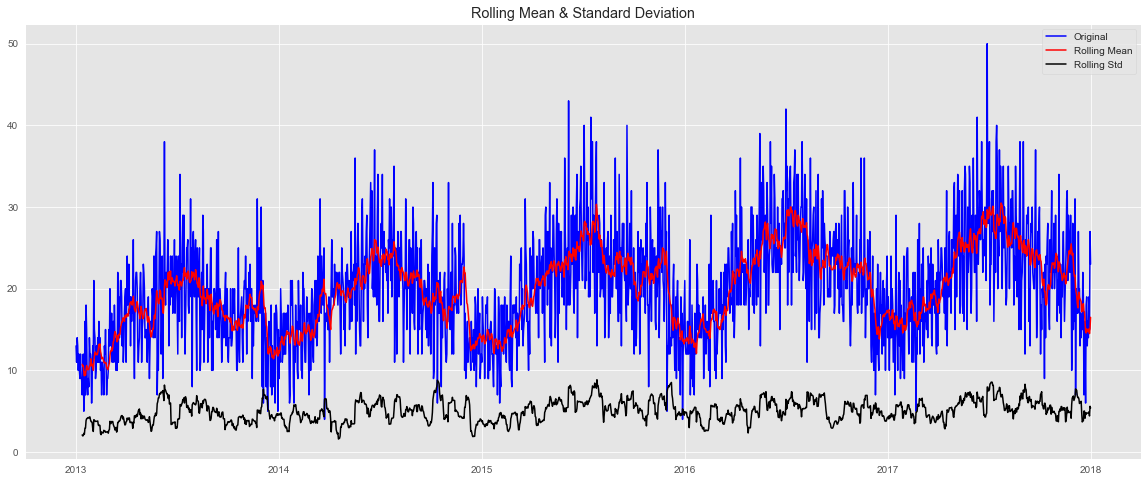

In [57]:
fig = plt.figure(figsize=(20, 8))
orig = plt.plot(timeseries, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

> Dickey-Fuller test

lag $k$의 의미? : $Y_t$ 와 $k$ 만큼 shift 시킨 $Y_t-k$ 사이의 연관성

In [51]:
dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
dfoutput = pd.Series(
    dftest[0:4], 
    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

In [52]:
dfoutput

Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
dtype: float64

`autolag='AIC'` : If ‘AIC’ (default) or ‘BIC’, then the number of lags is chosen to minimize the corresponding information criterion.

https://datascienceschool.net/view-notebook/ebb638fc880145b9adeef8dfa630f067/

In [53]:
cutoff = 0.01

dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < cutoff:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

print(dfoutput)

p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [56]:
# 함수로 만듭니다.
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    # Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

사실, p-value 0.036의 값은 critical value를 0.05로 주면, 귀무가설을 기각하게 되므로 데이터가 stationary 하다고 판단할 수 있다. 하지만 데이터를 시각화했을때 시간이 흐를수록 위쪽으로 상승하는 trend를 보였기 때문에, critical value를 엄격하게 설정하였다.

Stationary data를 얻기 위해서는 다른 techinque들도 존재한다.

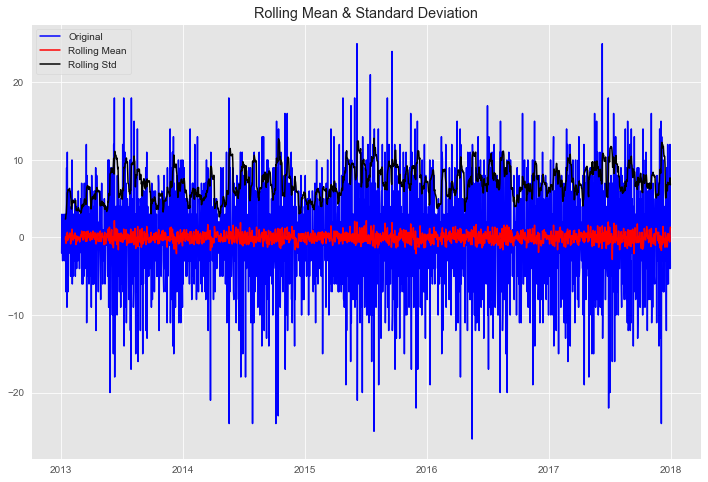

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [58]:
# Differencing
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

Differencing 이후에 p-value는 크게 작아졌다. 따라서 이 series는 stationary 데이터라고 볼 수 있습니다.

## (2) ACF and PACF

- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

- Autocorrelation에서 auto가 붙는 이유는, 자기자신(auto or self)의 데이터를 사용하여 자기 자신의 데이터를 예측하기 때문에 이렇게 이름이 지어졌습니다.

### (2.1) Autoregression(AR)

AR(p) (AutoRegressive of order p)는 간단하게 과거의 패턴이 지속된다면 시계열 데이터 관측치 $y_t$는 과거 관측치 $y_{t-1}$, $y_{t-2}$, $y_{t-3}$,..., $y_{t-p}$에 의해 예측될 수 있다고 봅니다. 오직 과거의 데이터(lagged variables)만 사용해서 예측 모형을 만들게 되며, 이름도 autoregressive 입니다. (그리스어로 auto 라는 뜻은 self를 가르킵니다.)

Autoregression은 이전 time-steps의 observations을 통해 다음 step의 값을 예측할 수 있다는 가정을 갖고 있습니다. Variables관의 관계를 correlation이라고 하며, 두 variables이 동시에 증가하거나 감소하면 positive correlation이라고 하며, 서로 반대방향으로 움직인다면 (하나는 증가하고, 하나는 감소하는 상황.) negative correlation이라고 합니다.

Output variable (예측값) 그리고 이전 time-steps의 값(lagged variables)들의 correlation을 구함으로서 통계적 측정을 할 수 있습니다.
correlation을 통해서 얼마만큼의 lag variables을 사용해야될지 알 수 있으며, 그래프가 predictable한지 안 한지도 알 수 있습니다.

Lag가 $k$인 Autoregression(AR) process를 이용하여 time series를 생성했다고 가정해보겠습니다.

ACF는 한 시점에서의 observarion과 그 이전 시점에서의 다른 observation(lag) 사이의 autocorrelation을 나타냅니다. 그리고 한 시점에서의 observation과 이전 시점에서의 다른 observation은 직/간접적으로 의존적인 정보를 포함하고 있습니다.
(예를 들어, 교회 수 $x$와 범죄발생 수$z$의 상관관계가 0.99라고 하자. 인구 수 $z$가 여기에 큰 영향을 미치기 때문이다. ACF는 $x$와 $y$의 상관계수를 계산할 때, $z$의 영향력을 포함시켜서 계산한다.)

PACF는 observation과 lag간의 직접적인 관계를 이용합니다. 따라서 observation과 $k$ 시점 뒤의 lag value와는 상관관계가 없을 수 있습니다.
(예를 들어, 교회 수 $x$와 범죄발생 수$z$의 상관관계가 0.99라고 하자. 인구 수 $z$가 여기에 큰 영향을 미치기 때문이다. PACF는 $x$와 $y$의 상관계수를 계산할 때, $z$의 영향력을 제외시켜서 계산한다.)

A pure Auto Regressive (AR only) model is one where $Y_t$ depends only on its own lags. That is, $Y_t$ is a function of the ‘lags of $Y_t$’.

$$Y_t=\alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2} + ... + \beta_pY_{t-p} + \epsilon_1$$

where, 
- $Y_{t-1}$ is the lag1 of the series.
- $\beta_1$ is the coefficient of lag1 that the model estimates.
- $\alpha$ is the intercept term, also estimated by the model.

### (2.2) Moving Average(MA)

Moving-average Model은 univariate time series를 모델링 하는데 사용되는 방법중의 하나입니다. AR Model과 함께 ARMA 그리고 ARIMA 모델의 중요 컴포넌트가 됩니다. Moving Average Model은 Moving Average와 전혀 다릅니다. 또한 AR과 다르게 MA는 항상 stationary 입니다. Moving average process는 prior prediction으로부터의 residual error의 time series autoregression model입니다. Moving average model은 현재의 forecast error를 기반으로 future forecast를 수정합니다.

A pure Auto Regressive (AR only) model is one where $Y_t$ depends only on its own lags. That is, $Y_t$ is a function of the ‘lags of $Y_t$’.

$$Y_t=\alpha + \epsilon_t + \phi_{1}\epsilon_{t-1} + \phi_{2}\epsilon_{t-2} + ... + \phi_{q}\epsilon_{t-q}$$

where the error terms are the errors of the autoregressive models of the respective lags. The errors $\epsilon_t$ and $\epsilon_{t-1}$ are the errors from the following equations :
$$Y_t=\beta_1Y_{t-1} + \beta_2Y_{t-2} + ... + \beta_0Y_{0} + \epsilon_t$$

$$Y_{t-1}=\beta_1Y_{t-2} + \beta_2Y_{t-3} + ... + \beta_0Y_{0} + \epsilon_{t-1}$$

Autocorrelation plot 으로 부터, MA term이 필요한지의 여부를 판단할 수 있습니다. Partial autocorrelation plot으로부터 AR term이 필요한지의 여부를 판단할 수 있습니다.

> Lag plot

빠르게 correlation이 존재하는지 확인하는 방법은 step t 와 t-1 을 scatter plot으로 그래서 확인하는 방법입니다. 자기상관관계가 있으면 직선의 형태로 scatter가 형성되고, 자기상관관계가 없으면 random하게 scatter가 형성됩니다.

Text(0.5, 1.0, 'lag plot')

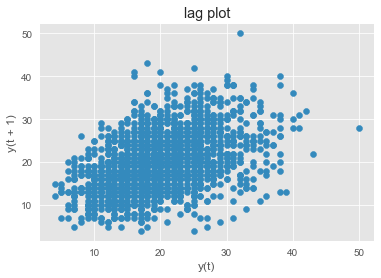

In [62]:
from pandas.plotting import lag_plot

lag_plot(timeseries, lag=1)
plt.title('lag plot')

> Pearson Correlation Coefficient

In [63]:
first_diff = train_df.sales - train_df.sales.shift(1)
second_diff = train_df.sales - train_df.sales.shift(2)

data2 = pd.concat([second_diff, first_diff, train_df.sales], axis=1)
data2.columns = ['t-2', 't-1', 't']
data2.corr()

,t-2,t-1,t
t-2,1.000000,0.535605,0.562809
t-1,0.535605,1.000000,0.525338
t,0.562809,0.525338,1.000000


> Autocorrelation Plot

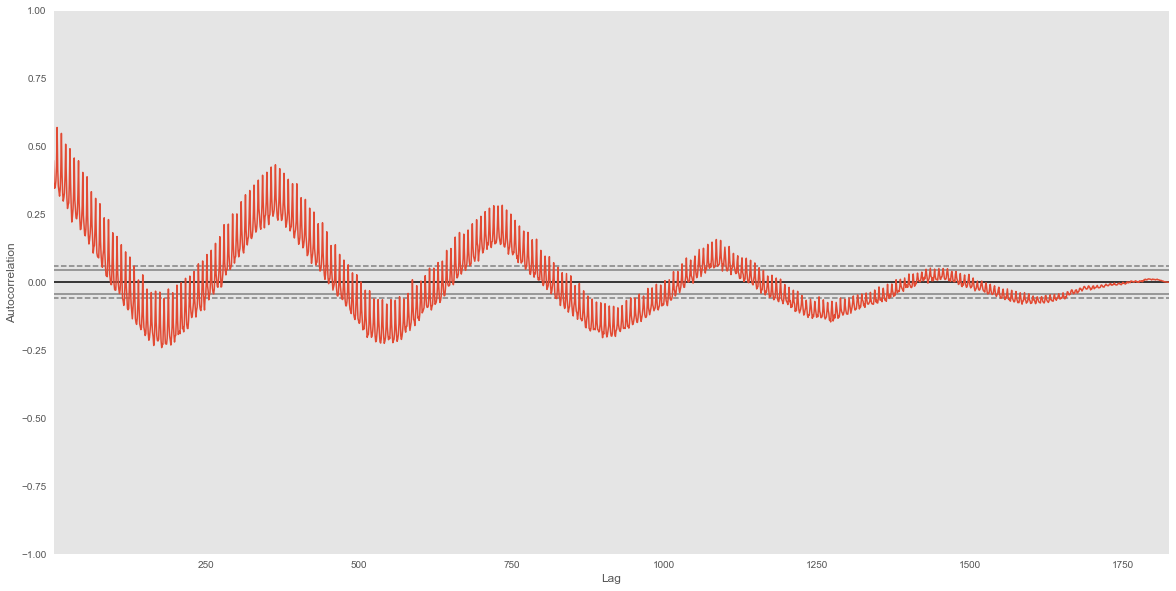

In [65]:
from pandas.plotting import autocorrelation_plot

figure = plt.figure(figsize=(20, 10))
autocorrelation_plot(timeseries)

> ACF, PACF

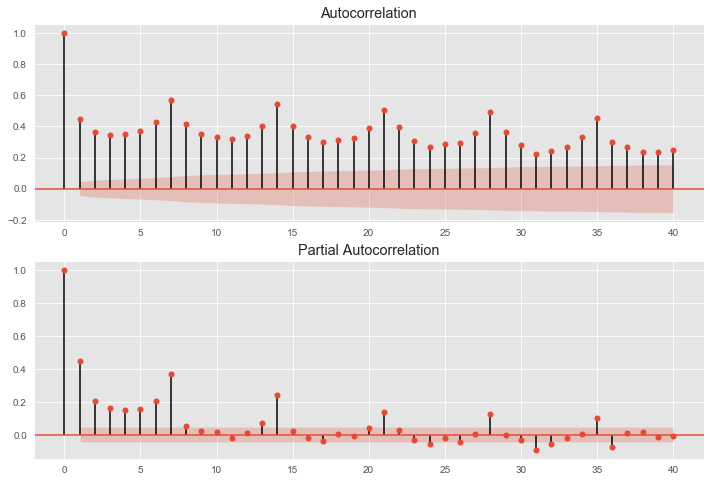

In [59]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)

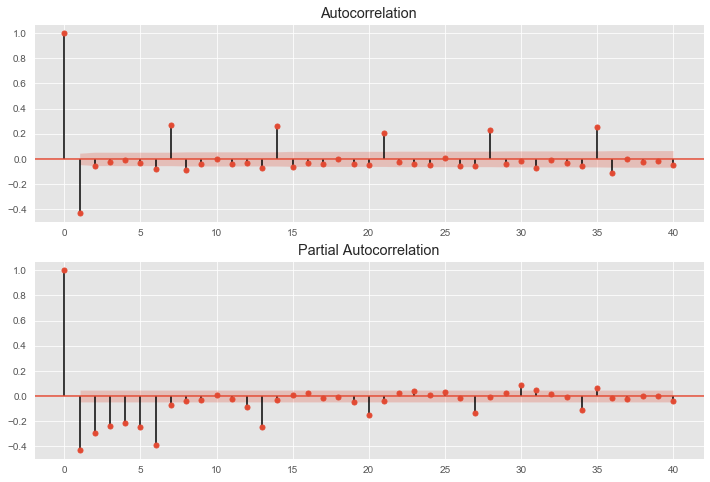

In [60]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

7일 단위로 pattern이 반복되는 것을 볼 수 있습니다. Seasonal이 존재한다고 판단할 수 있으며, SARIMA(Seasonal ARIMA)의 사용을 검토하도록 합니다.

## (3) Build the model

### How to determin p, d, q

- I = 1 : First order differencing이 time series를 stationary 하게 함
- AR = 6 : 6 lags에서 AR이 significant (PACF)
- MA = 0 : PACF에서 마지막으로 관찰된 유의한 term

https://www.researchgate.net/post/How_does_one_determine_the_values_for_ARp_and_MAq   
https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms/281726#281726  
https://stats.stackexchange.com/questions/134487/analyse-acf-and-pacf-plots?rq=1  

In [67]:
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Sun, 09 Jun 2019   AIC                          11211.335
Time:                        23:32:22   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

### Analyze the result
- Residual distribution (normal dist or not)
- ACF, PACF

좋은 모델 :
 - The residual is normal distribution.
 - ACF, PACF has not significant terms.

> Residual dist

In [72]:
from scipy import stats
from scipy.stats import normaltest

# Residual의 normal test
resid = arima_mod6.resid
print(normaltest(resid))

NormaltestResult(statistic=16.42639258283117, pvalue=0.00027105297095259895)


Text(0.5, 1.0, 'Residual distribution')

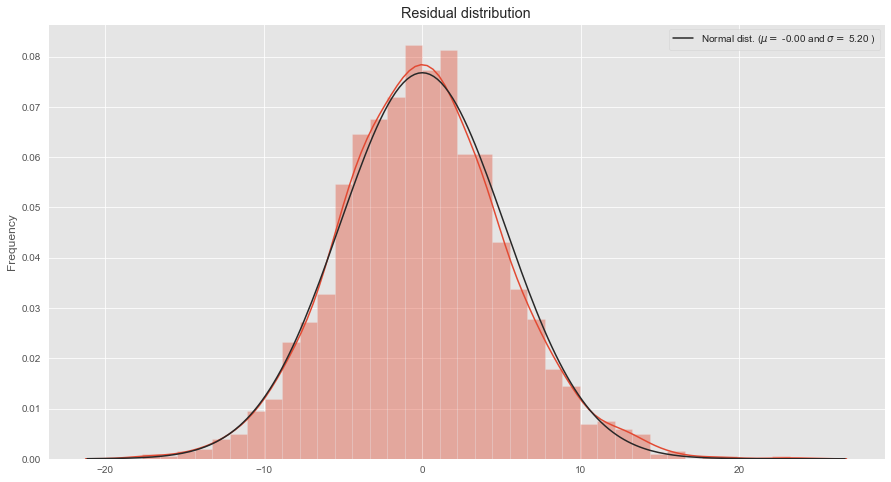

In [75]:
fig = plt.figure(figsize=(15,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid, fit = stats.norm, ax = ax0)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

> ACF and PACF

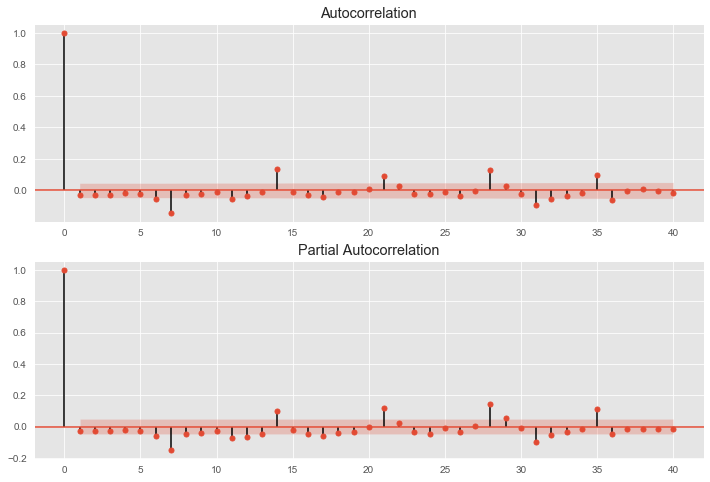

In [76]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

ACF and PACF에서 correlation이 반복적으로 발생하고 있다. 따라서 SARIMA를 고려해야한다.

# Consider seasonality affect by SARIMA

In [77]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Sun, 09 Jun 2019   AIC                          11209.359
Time:                        23:40:48   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

> Residual dist

NormaltestResult(statistic=16.74269014620744, pvalue=0.0002314040888974918)


Text(0.5, 1.0, 'Residual distribution')

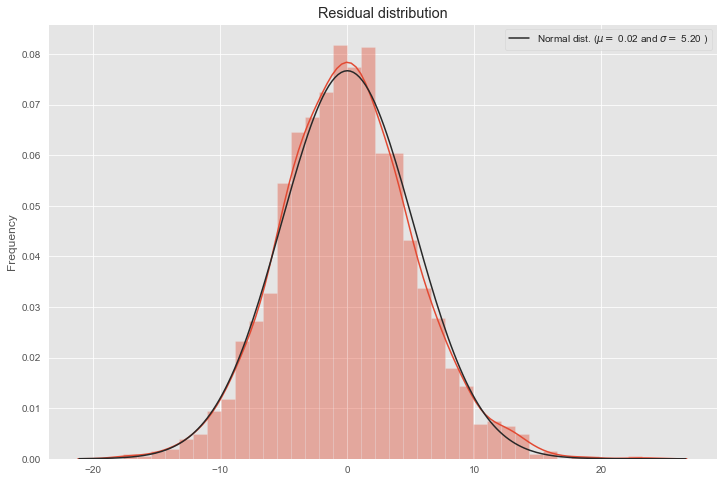

In [78]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

> ACF and PACF

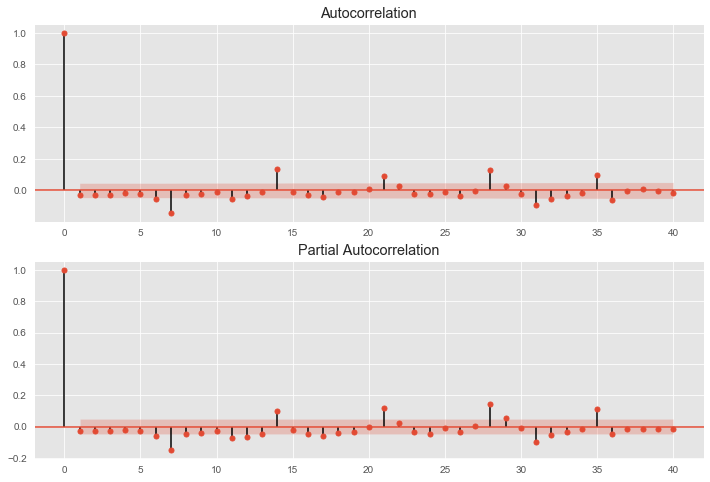

In [79]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

# Make prediction and evaluation

Take the last 30 days in training set as validation data

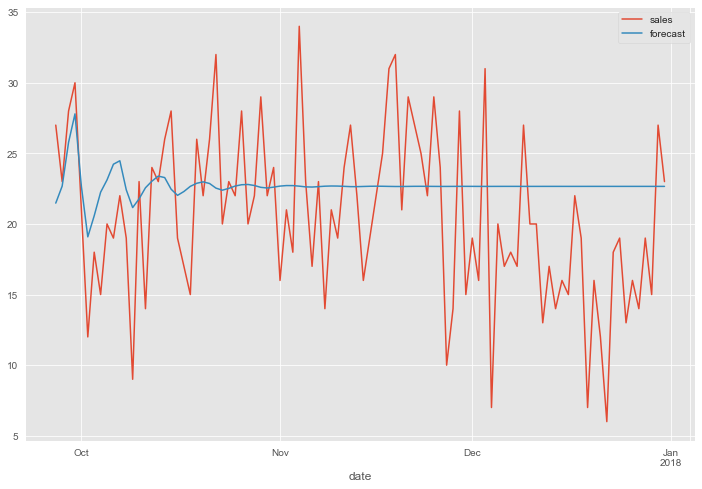

In [80]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [81]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [82]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


# SARIMAX: adding external variables

In [85]:
storeid = 1
itemid = 1

train_df = train[train['store']==storeid]
train_df = train_df[train_df['item']==itemid]

train_df['year'] = train_df['date'].dt.year - 2012
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.dayofyear
train_df['weekday'] = train_df['date'].dt.weekday

start_index = 1730
end_index = 1826

In [86]:
train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,1,1,1,1
1,2013-01-02,1,1,11,1,1,2,2
2,2013-01-03,1,1,14,1,1,3,3
3,2013-01-04,1,1,13,1,1,4,4
4,2013-01-05,1,1,10,1,1,5,5


In [99]:
holiday = pd.read_csv('./inputs/usholidays.csv', index_col=0)
holiday.columns = ['date', 'holiday']
holiday['date'] = pd.to_datetime(holiday['date'], yearfirst = True)
holiday.head()

,date,holiday
0,2010-12-31,New Year's Day
1,2011-01-17,"Birthday of Martin Luther King, Jr."
2,2011-02-21,Washington's Birthday
3,2011-05-30,Memorial Day
4,2011-07-04,Independence Day


In [100]:
train_df = train_df.merge(holiday, how='left', on='date')
train_df['holiday_bool'] = pd.notnull(train_df['holiday']).astype(int)
train_df = pd.get_dummies(train_df, 
                          columns = ['month','holiday','weekday'] , 
                          prefix = ['month','holiday','weekday'])
train_df.head()

,date,store,item,sales,year,day,holiday_bool,month_1,month_2,month_3,...,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washington's Birthday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2013-01-01,1,1,13,1,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2013-01-02,1,1,11,1,2,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2013-01-03,1,1,14,1,3,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2013-01-04,1,1,13,1,4,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2013-01-05,1,1,10,1,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [103]:
ext_var_list = ['date','year', 'day', 'holiday_bool',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'holiday_Christmas Day', 'holiday_Columbus Day',
       'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Memorial Day', 'holiday_Thanksgiving Day', 'holiday_Veterans Day', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6']

In [104]:
exog_data = train_df[ext_var_list]
exog_data = exog_data.set_index('date')
exog_data.head()

,year,day,holiday_bool,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,holiday_Memorial Day,holiday_Thanksgiving Day,holiday_Veterans Day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2013-01-02,1,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,1,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,1,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,1,5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [105]:
train_df = train_df.set_index('date')
train_df.head()

,store,item,sales,year,day,holiday_bool,month_1,month_2,month_3,month_4,...,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washington's Birthday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2013-01-02,1,1,11,1,2,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,1,1,14,1,3,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,1,1,13,1,4,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,1,1,10,1,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [106]:
start_index = '2017-10-01'
end_index = '2017-12-31'

In [107]:
%%time
sarimax_mod6 = sm.tsa.statespace.SARIMAX(endog = train_df.sales[:start_index],
                                         exog = exog_data[:start_index],  
                                         trend='n', order=(6,1,0), seasonal_order=(0,1,1,7)).fit()
print(sarimax_mod6.summary())

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1735
Model:             SARIMAX(6, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -5133.434
Date:                           Mon, 10 Jun 2019   AIC                          10340.869
Time:                                   00:01:58   BIC                          10542.672
Sample:                               01-01-2013   HQIC                         10415.518
                                    - 10-01-2017                                         
Covariance Type:                             opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
year                      -244.4924   1564.171     -0.156      0.876   -3310.212    2821.227
d

대부분의 coefficient들이 유의하지 않습니다. 이것은 데이터 사이의 high collinearity 때문일 수 있습니다.

In [109]:
start_index = '2017-10-01'
end_index = '2017-12-30'
end_index1 = '2017-12-31'

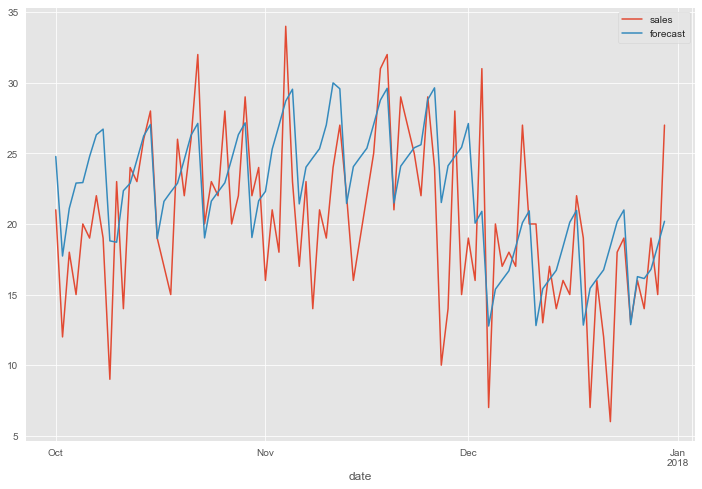

In [111]:
train_df['forecast'] = sarimax_mod6.predict(start = pd.to_datetime(start_index), end= pd.to_datetime(end_index1),
                                            exog = exog_data[start_index:end_index], 
                                            dynamic= True)  

train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [112]:
smape_kun(train_df[start_index:end_index]['sales'],train_df[start_index:end_index]['forecast'])

MAPE: 26.05 % 
SMAPE: 21.39 %
